<a href="https://colab.research.google.com/github/chitransh0052/Machine-learning/blob/main/Blood_Cell_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d sumithsingh/blood-cell-images-for-cancer-detection

Dataset URL: https://www.kaggle.com/datasets/sumithsingh/blood-cell-images-for-cancer-detection
License(s): Attribution 4.0 International (CC BY 4.0)


In [10]:
!unzip -q blood-cell-images-for-cancer-detection.zip -d blood_cancer_dataset

In [11]:
!ls

blood_cancer_dataset  blood-cell-images-for-cancer-detection.zip  kaggle.json  sample_data


In [12]:
import os

image_path = "blood_cancer_dataset"
subfolders = os.listdir(image_path)

print("Subfolders found:", subfolders)  # This should print all subfolders

Subfolders found: ['monocyte', 'myeloblast', 'seg_neutrophil', 'basophil', 'erythroblast']


In [13]:
sample_folder = os.path.join(image_path, subfolders[0])  # First subfolder
image_files = os.listdir(sample_folder)

print(f"Total images in {subfolders[0]}:", len(image_files))
print("First 5 images:", image_files[:5])

Total images in monocyte: 1000
First 5 images: ['MO_134722.jpg', 'MO_770326.jpg', 'MO_692135.jpg', 'MO_612179.jpg', 'MO_104431.jpg']


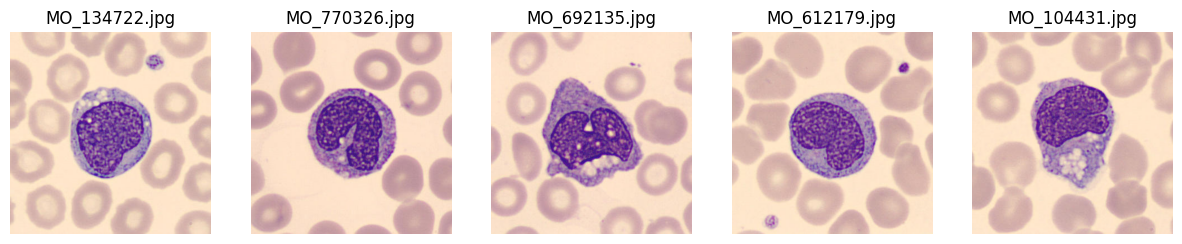

In [14]:
import cv2
import matplotlib.pyplot as plt

# Get all image file paths inside subfolders
all_images = []
for subfolder in subfolders:
    folder_path = os.path.join(image_path, subfolder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        all_images.append(img_path)

# Display first few images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, img_path in enumerate(all_images[:5]):  # Take first 5 images
    img = cv2.imread(img_path)

    if img is None:
        print(f"Skipping {img_path} (not readable)")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(os.path.basename(img_path))

plt.show()

In [15]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [16]:
# Set image dimensions and paths
IMAGE_SIZE = (128, 128)  # Resize images to 128x128
DATASET_PATH = "blood_cancer_dataset"

In [17]:
# Get subfolders (class names)
class_names = os.listdir(DATASET_PATH)
print("Classes:", class_names)

Classes: ['monocyte', 'myeloblast', 'seg_neutrophil', 'basophil', 'erythroblast']


In [18]:
# Load dataset
def load_dataset(image_size=IMAGE_SIZE):
    images, labels = [], []

    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(DATASET_PATH, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Skipping corrupted image: {img_path}")
                continue

            img = cv2.resize(img, image_size)  # Resize
            img = img / 255.0  # Normalize (0-1 range)

            images.append(img)
            labels.append(class_index)

    return np.array(images), np.array(labels)

In [19]:
# Load and split the dataset
X, y = load_dataset()
print("Total images:", X.shape[0])

Total images: 5000


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Training images:", X_train.shape[0], "Testing images:", X_test.shape[0])

Training images: 4000 Testing images: 1000


In [21]:
# Create Custom CNN Model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Prevent overfitting
        Dense(len(class_names), activation='softmax')  # Output layer (Number of classes)
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [22]:
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Callbacks (Early Stopping and Checkpoint)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

In [24]:
# Train the Model without Data Augmentation
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=32,
                    callbacks=callbacks)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3672 - loss: 1.4277

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.3682 - loss: 1.4258 - val_accuracy: 0.8360 - val_loss: 0.7069
Epoch 2/20
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7342 - loss: 0.7155

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7354 - loss: 0.7131 - val_accuracy: 0.8940 - val_loss: 0.3838
Epoch 3/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8468 - loss: 0.4787

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8470 - loss: 0.4779 - val_accuracy: 0.9300 - val_loss: 0.2530
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9062 - loss: 0.3087

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9062 - loss: 0.3086 - val_accuracy: 0.9310 - val_loss: 0.2052
Epoch 5/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9205 - loss: 0.2583

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9206 - loss: 0.2581 - val_accuracy: 0.9400 - val_loss: 0.1853
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9265 - loss: 0.2376 - val_accuracy: 0.9300 - val_loss: 0.1893
Epoch 7/20
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9359 - loss: 0.2229

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9361 - loss: 0.2225 - val_accuracy: 0.9400 - val_loss: 0.1584
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9403 - loss: 0.1801

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9403 - loss: 0.1801 - val_accuracy: 0.9460 - val_loss: 0.1245
Epoch 9/20
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9481 - loss: 0.1704

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9481 - loss: 0.1705 - val_accuracy: 0.9500 - val_loss: 0.1225
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9541 - loss: 0.1407 - val_accuracy: 0.9530 - val_loss: 0.1302
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9547 - loss: 0.1484 - val_accuracy: 0.9500 - val_loss: 0.1362
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9596 - loss: 0.1279

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9595 - loss: 0.1280 - val_accuracy: 0.9510 - val_loss: 0.1157
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9543 - loss: 0.1409 - val_accuracy: 0.9520 - val_loss: 0.1211
Epoch 14/20
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9573 - loss: 0.1285

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9573 - loss: 0.1286 - val_accuracy: 0.9650 - val_loss: 0.1019
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9576 - loss: 0.1301 - val_accuracy: 0.9620 - val_loss: 0.1106
Epoch 16/20
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9580 - loss: 0.1310

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9581 - loss: 0.1307 - val_accuracy: 0.9620 - val_loss: 0.1002
Epoch 17/20
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9676 - loss: 0.0981

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9675 - loss: 0.0983 - val_accuracy: 0.9650 - val_loss: 0.0989
Epoch 18/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9686 - loss: 0.1131 - val_accuracy: 0.9590 - val_loss: 0.1100
Epoch 19/20
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9609 - loss: 0.1165

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9611 - loss: 0.1161 - val_accuracy: 0.9740 - val_loss: 0.0875
Epoch 20/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9753 - loss: 0.0871 - val_accuracy: 0.9710 - val_loss: 0.0915


In [25]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9766 - loss: 0.0773

✅ Test Accuracy: 97.40%


In [26]:
# Save the Model
model.save("blood_cancer_cnn.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


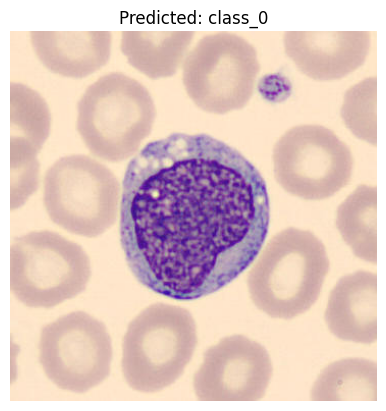

Model Prediction: class_0


In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ensure the model is compiled before making predictions
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define function to predict image
def predict_image(img_path, model, class_names):
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at {img_path}")
        return

    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Image not loaded! Check file format and path.")
        return

    # Preprocess the image
    img = cv2.resize(img, (128, 128))  # Resize to match model input size
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Expand dimensions for model input

    # Make prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    class_label = class_names[predicted_class]

    # Display image with prediction
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Predicted: {class_label}")
    plt.show()

    return class_label

# Define class names (Update this list as per your dataset)
class_names = ["class_0", "class_1", "class_2", "class_3"]  # Replace with actual class labels

# Path to the test image
test_image_path = os.path.join("blood_cancer_dataset", "monocyte", "MO_134722.jpg")

# Run prediction
prediction = predict_image(test_image_path, model, class_names)
print("Model Prediction:", prediction)